# Wine quality - Elastic Net model

In [2]:
import pandas as pd
import numpy  as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
####################################### ML libs
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

%matplotlib ipympl

In [3]:
df = pd.read_csv('./winequality-red.csv')
df.head(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


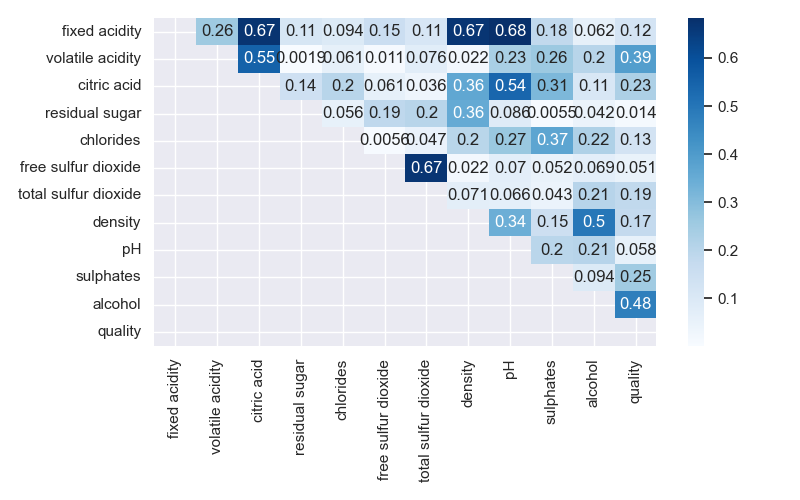

In [4]:
fig_1, ax_1 = plt.subplots(figsize=(8,5))
sns.heatmap(df.corr().abs(), cmap='Blues', annot=True, mask=np.tril(df.corr()))
plt.tight_layout()

In [5]:

qual_corr = df.corr().abs().sort_values(by='quality',ascending=False)
qual_corr['quality']


quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

Here the correlation between the features and the quality of the wines is very small for values bellow 0.1. Lets try with drop these features in the future.

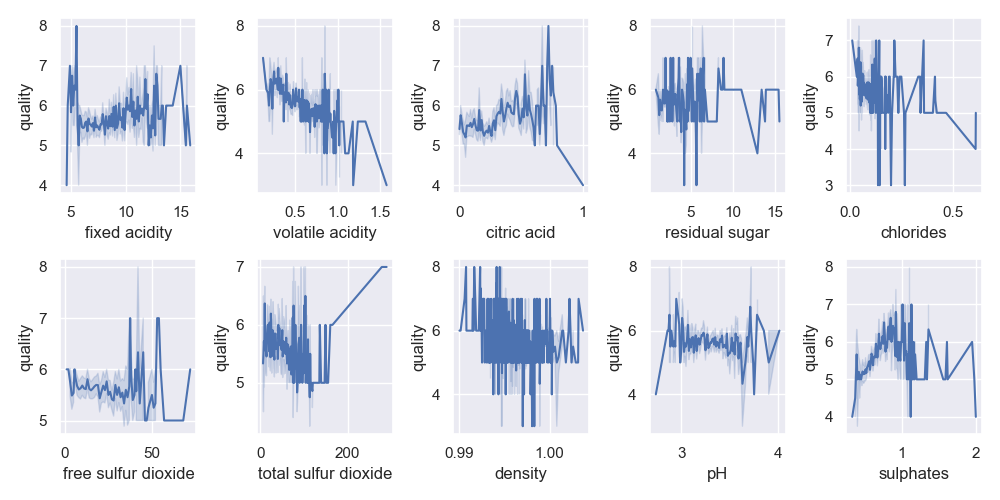

In [6]:
fig, axs = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.lineplot(data=df,x=df.columns[i],y='quality', ax=axs[0][i])
    sns.lineplot(data=df,x=df.columns[i+5],y='quality', ax=axs[1][i])
plt.tight_layout()

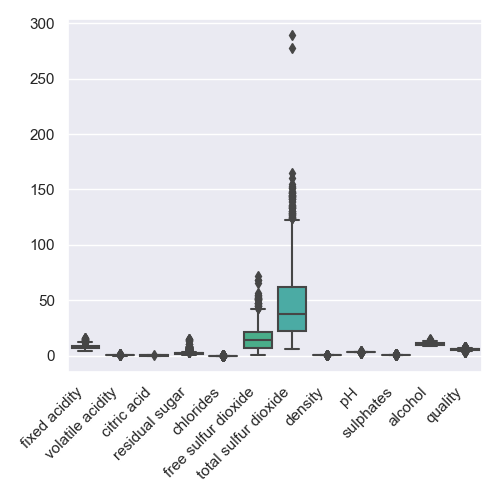

In [7]:
fig0, ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(data=df);

ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

**Empirical distribution**

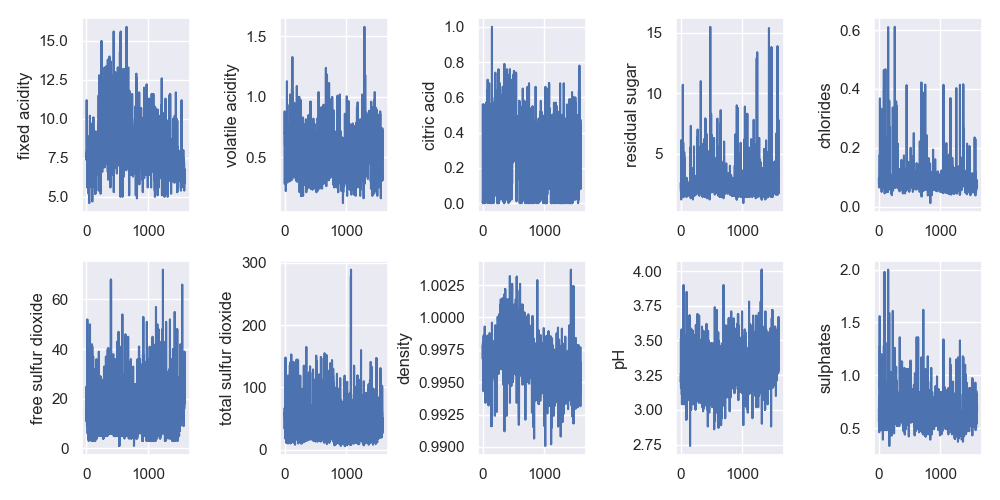

In [8]:
fig1, axs1 = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.lineplot(data=df,y=df.columns[i],x=df.index, ax=axs1[0][i])
    sns.lineplot(data=df,y=df.columns[i+5],x=df.index, ax=axs1[1][i])
plt.tight_layout()

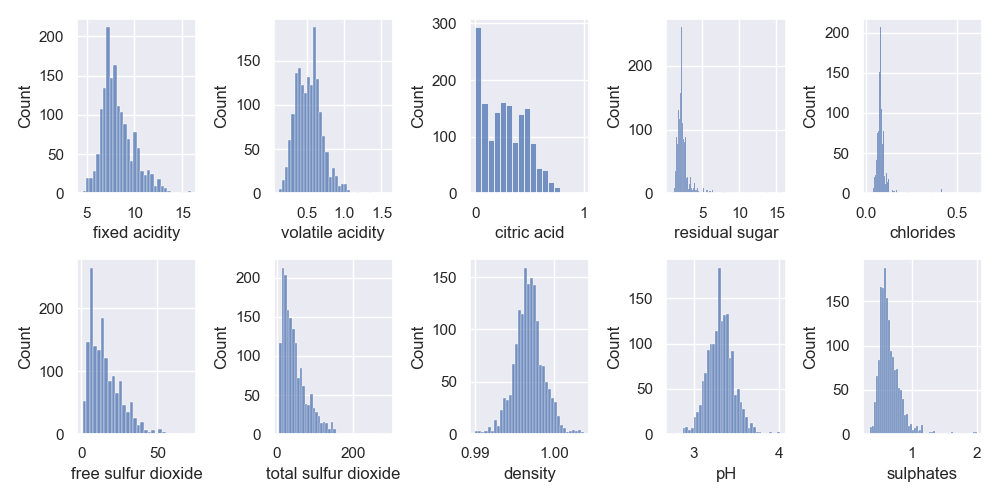

In [9]:
fig2, axs2 = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.histplot(df[df.columns[i]],   ax=axs2[0][i])
    sns.histplot(df[df.columns[i+5]], ax=axs2[1][i])
plt.tight_layout()

The distributions seems to be all like Poisson distribution. It might be better to normalize (scale) the data frame because ``total sulfure dioxide`` feature is 2 orders the magnitude more than features like ``pH``, ``sulphates`` or ``citric acid``.

# Functions

**CV error**

In [10]:
import sklearn.linear_model as lm
from sklearn.model_selection import KFold

def cv_error(x_train, y_train, k, method='OLS', alpha=1): #OLS: Regresión Lineal Ordinaria
    
    # Esta función calcula el error de validación cruzada y recopila 
    # los coeficientes de modelos de regresión regularizados en cada fold (k). 
    
    # Matriz de atributos y vector objetivo. 
    Xm, ym = x_train.values, y_train.values
    # dividimos el conjunto de entrenamiento en k particiones
    kf = KFold(n_splits=k)
    # Root Mean Squared Error Cross-Validation: Es una métrica que se utiliza para evaluar 
    # la calidad del modelo de regresión en cada fold de la validación cruzada y, 
    # finalmente, proporciona una medida general del rendimiento del modelo. Cuanto menor
    # sea el valor de rmse_cv, mejor será el rendimiento del modelo, ya que indicaría que
    # las predicciones del modelo se ajustan de manera más cercana a los datos reales.
    rmse_cv = 0
    # guardamos los coeficientes 
    coef_v = []

    # definimos el method_type en función del valor de method
    if method == 'OLS':
        method_type = lm.LinearRegression(fit_intercept=False)
    elif method == 'ridge':
        method_type = lm.Ridge(alpha=alpha, fit_intercept=False)
    elif method == 'lasso':
        method_type = lm.Lasso(alpha=alpha, fit_intercept=False)
    elif method == 'enet':
        method_type = lm.ElasticNet(alpha=alpha, fit_intercept=False)
    else:
        # Error de argumento invalido 
        raise TypeError("Method argument is not valid")

    # para cada partición del conjunto de entrenamiento
    for train_index, validation_index in kf.split(Xm):
        # definimos el método
        method_type = method_type
        # hacemos fit de los datos randomizados
        method_type.fit(Xm[train_index], ym[train_index])
        # agregamos los valores de los coeficientes
        coef_v.append(method_type.coef_)
        # predecimos los valores de validación
        yhat_validation = method_type.predict(Xm[validation_index])
        # reescribimos la metrica rmse para cada fold
        rmse_cv += np.mean(np.power(yhat_validation - ym[validation_index], 2))

    # creamos un df con los coeficientes
    coefs_dataframe = pd.DataFrame(
        # para cada array de coeficientes reordenamos los valores 
        [[fold[x] for x in range(x_train.shape[1])] for fold in coef_v]
    )

    # retorna los coeficientes y el rmse_cv
    coefs_dataframe.columns = list(x_train.columns)
    return coefs_dataframe, rmse_cv

**regularization report function**

In [11]:
def report_regularization (model, X_test, y_test,observation=''):
    print('\n{}'.format(observation))
    print( 'Regularization parameters values: {0}' .format(model.alpha_))
    print( 'Final coefficients: \n{0}' .format(model.coef_))
    y_hat = model.predict(X_test)
    print( 'R-squared: {0}' .format(r2_score(y_test,y_hat).round(2)))
    print( 'Mean Squared Error: {0}' .format(mean_squared_error(y_test, y_hat).round(2)))
    


# Elastic Net model

## Preprocessing data

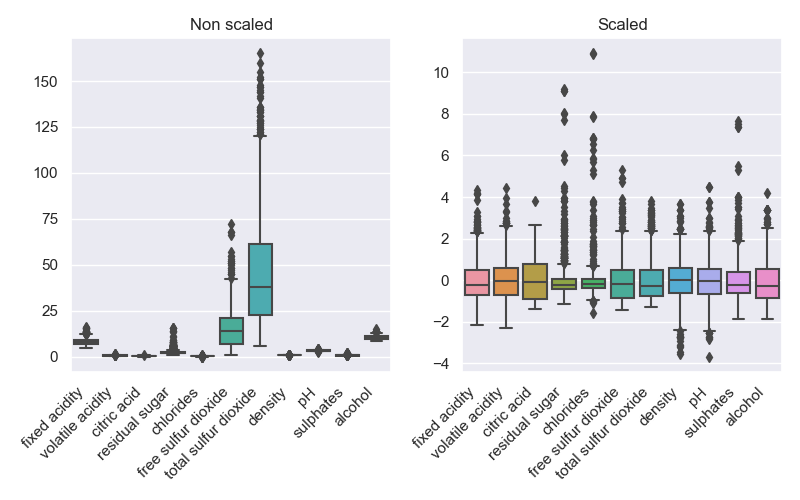

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality',axis=1)
y = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

fig3, ax3 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= ax3[0]).set_title('Non scaled');
ax3[0].set_xticklabels(ax3[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=ax3[1]).set_title('Scaled');
ax3[1].set_xticklabels(ax3[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

100%|██████████| 50/50 [00:00<00:00, 58.58it/s]


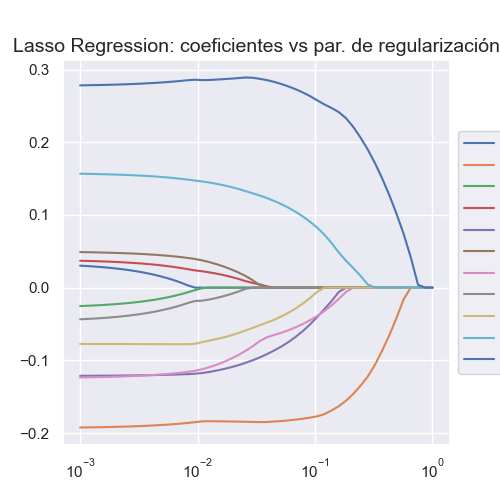

In [17]:
features = X.columns
lambdas  = np.logspace(0,-3,base=10)
coef_lasso    = [] #coefisisients of the lasso model
cv_err_lasso  = [] #errors of the lasso model


###################################################   Model
model_enet = ElasticNet(fit_intercept=True)

###################################################   Fitting
for ll in tqdm(lambdas):
    # Parameter setting
    model_enet.set_params(alpha=ll)
    # Fitting of the Model
    model_enet.fit(Xtrain_sc,y_train)
    #Saving coefficients
    coef_lasso.append(model_enet.coef_)
    
    _ , cv_err_estimates = cv_error(Xtrain_sc, y_train, k=10, method='enet', alpha=ll)
    cv_err_lasso.append(np.mean(cv_err_estimates))

fig4, ax4 =plt.subplots(figsize=(5,5))

for y_arr, label in zip(np.squeeze(coef_lasso).T,features):
    ax4.plot(lambdas, y_arr,label=label)

ax4.legend()
ax4.set_xscale('log')
plt.axis("tight")
plt.legend(loc = "center left" , bbox_to_anchor=(1, .5))
plt.title("Lasso Regression: coeficientes vs par. de regularización", fontsize =14)
plt.tight_layout
plt.show()

**Lambda values**

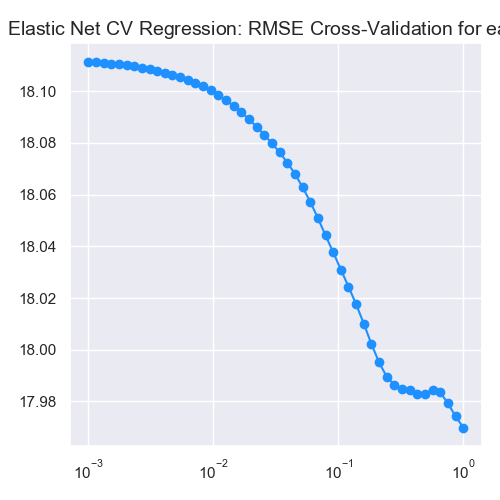

In [18]:
fig5, ax5 =plt.subplots(figsize=(5,5))
ax5.plot(lambdas, np.sqrt(cv_err_lasso), 'o-',color= 'dodgerblue')
ax5.set_xscale("log")
plt.title("Elastic Net CV Regression: RMSE Cross-Validation for each $\lambda$", fontsize = 14)
plt.tight_layout()
plt.show()

Comparing with the Ridge model, [see here](https://github.com/PhyData/Wine_quality/blob/main/WineQuality_Ridge_and_ridgeCVphy.ipynb), the $\lambda$ values penalizes more abruptly some of the features than others reducing thus the features in the model and preserving the more relevant ones.

## Elastic Net CV model

Similarly to other regulation models like Ridge, Lasso also has a cross-validation model, which is much more simple to analize and simple to apply.

In [36]:
lambdas = np.logspace( 0 , -3 , base = 10 )
enet_cv = ElasticNetCV(cv=10,l1_ratio=lambdas)
model_enet = enet_cv.fit(X_train, y_train)
mserror1 = report_regularization(model_enet, X_test, y_test)




Regularization parameters values: 0.003572185766288961
Final coefficients: 
[ 0.02946011 -0.76961728 -0.          0.         -0.00228803 -0.
  1.4305698   0.28227672]
R-squared: 0.36
Mean Squared Error: 0.31


--------------
--------------
--------------
--------------
# Removing nearly uncorrelated features and outliners from the model

(1599, 12)


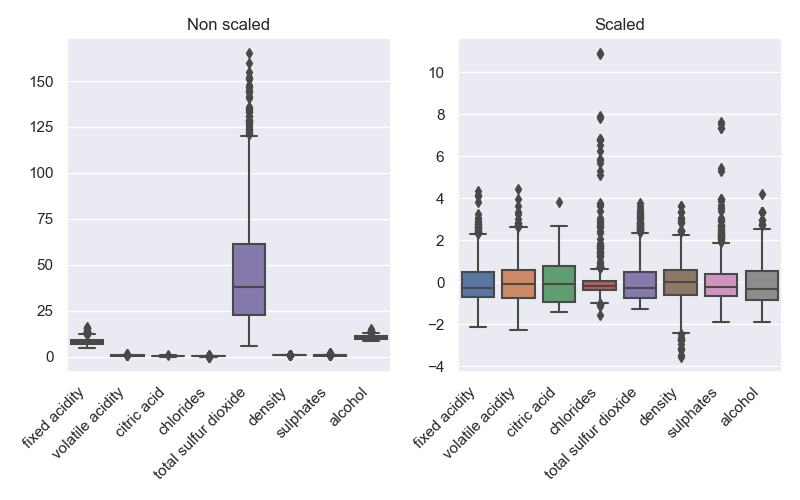

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('./winequality-red.csv')
# X = df.drop('quality',axis=1)
X  = df.drop(['quality','pH','free sulfur dioxide','residual sugar'],axis=1)
y  = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign0, axn0 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn0[0]).set_title('Non scaled');
axn0[0].set_xticklabels(axn0[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn0[1]).set_title('Scaled');
axn0[1].set_xticklabels(axn0[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()
print(df.shape)


**removing uncorrelated variables**

In [38]:
qual_corr = df.corr().abs().sort_values(by='quality',ascending=False)
corr_tol = 0.1
print('removing correlations bellow {}'.format(corr_tol))
qq = qual_corr[qual_corr['quality']<=corr_tol].index
df = df.drop(qq,axis=1)
df

removing correlations bellow 0.1


,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5
1,7.8,0.880,0.00,0.098,67.0,0.99680,0.68,9.8,5
2,7.8,0.760,0.04,0.092,54.0,0.99700,0.65,9.8,5
3,11.2,0.280,0.56,0.075,60.0,0.99800,0.58,9.8,6
4,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,0.090,44.0,0.99490,0.58,10.5,5
1595,5.9,0.550,0.10,0.062,51.0,0.99512,0.76,11.2,6
1596,6.3,0.510,0.13,0.076,40.0,0.99574,0.75,11.0,6
1597,5.9,0.645,0.12,0.075,44.0,0.99547,0.71,10.2,5


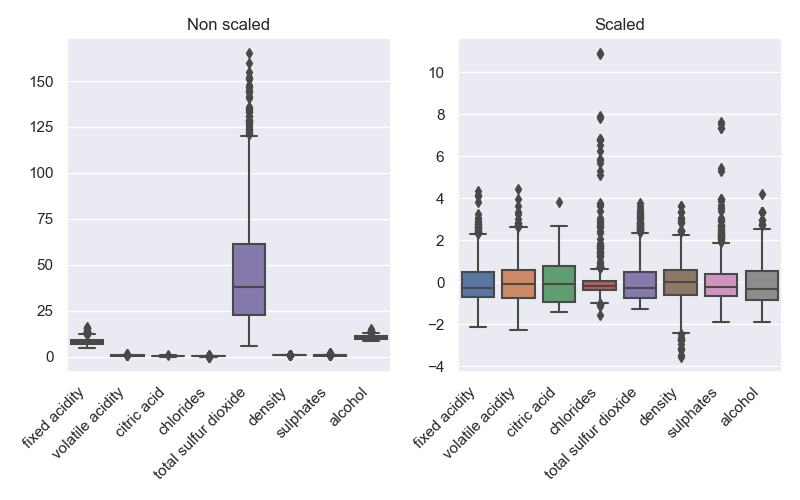

In [39]:

X = df.drop('quality',axis=1)
y = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign1, axn1 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn1[0]).set_title('Non scaled');
axn1[0].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn1[1]).set_title('Scaled');

axn1[1].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

**Removing the outliers in the DF**

In [31]:
dd = {}
for i in df.columns:  
    
    ff   = df[i]
    q1   = np.quantile(ff,0.25)
    q3   = np.quantile(ff,0.75)
    
    ir   = q3-q1
    atop = 1.2
    abot = 1.2
    topw = q3+atop*ir
    botw = q1-abot*ir
    ff   = ff[ df[i] < topw]
    
    ff   = ff[ df[i] > botw]
    dd[i] = ff
df_clean = pd.DataFrame(dd)
df_clean1 = df_clean.dropna()
display(df_clean1.head(5),df_clean1.shape)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5.0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5.0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5.0
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6.0
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5.0


(1164, 9)

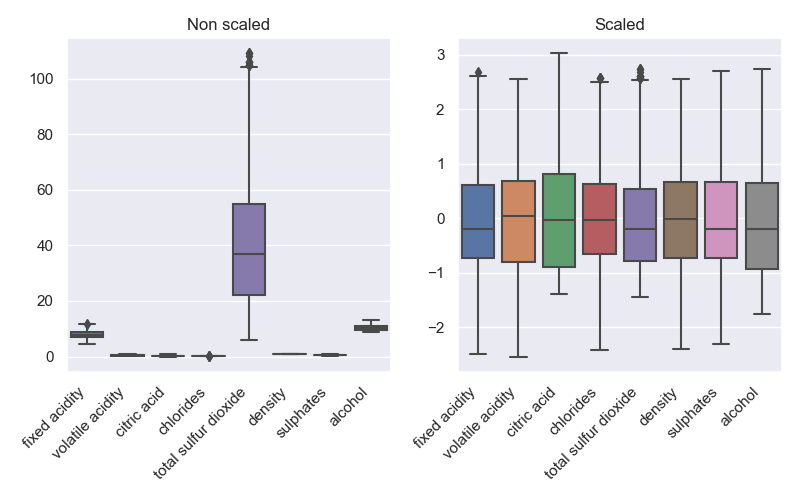

In [40]:
X = df_clean1.drop('quality',axis=1)
y = df_clean1['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign1, axn1 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn1[0]).set_title('Non scaled');
axn1[0].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn1[1]).set_title('Scaled');
axn1[1].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

In [43]:
lambdas = np.logspace( 0 , -3 , base = 10 )
enet_cv = ElasticNetCV(cv=10,l1_ratio=lambdas)
enet_cv2 = ElasticNetCV(cv=10,l1_ratio=lambdas)

#Scaled model
enet_cv = enet_cv.fit(Xtrain_sc,y_train) 

#nonscaled model
enet_cv_noscaled = enet_cv2.fit(X_train,y_train) 


In [44]:
def report_regularization (model, X_test, y_test,observation=''):
    print('\n{}'.format(observation))
    print( 'Regularization parameters values: {0}' .format(model.alpha_))
    print( 'Final coefficients: \n{0}' .format(model.coef_))
    y_hat = model.predict(X_test)
    print( 'R-squared: {0}' .format(r2_score(y_test,y_hat).round(2)))
    print( 'Mean Squared Error: {0}' .format(mean_squared_error(y_test, y_hat).round(2)))

In [45]:
#Lasso CV report
report_regularization(enet_cv,Xtest_sc,y_test,observation='****************** Scaled')
report_regularization(enet_cv_noscaled,X_test,y_test,observation='****************** Non Scaled')


****************** Scaled
Regularization parameters values: 0.032608701474210244
Final coefficients: 
[ 0.07187789 -0.15519161 -0.04862418  0.02805885 -0.05040264 -0.04050187
  0.1971246   0.24425424]
R-squared: 0.36
Mean Squared Error: 0.31

****************** Non Scaled
Regularization parameters values: 0.003572185766288961
Final coefficients: 
[ 0.02946011 -0.76961728 -0.          0.         -0.00228803 -0.
  1.4305698   0.28227672]
R-squared: 0.36
Mean Squared Error: 0.31


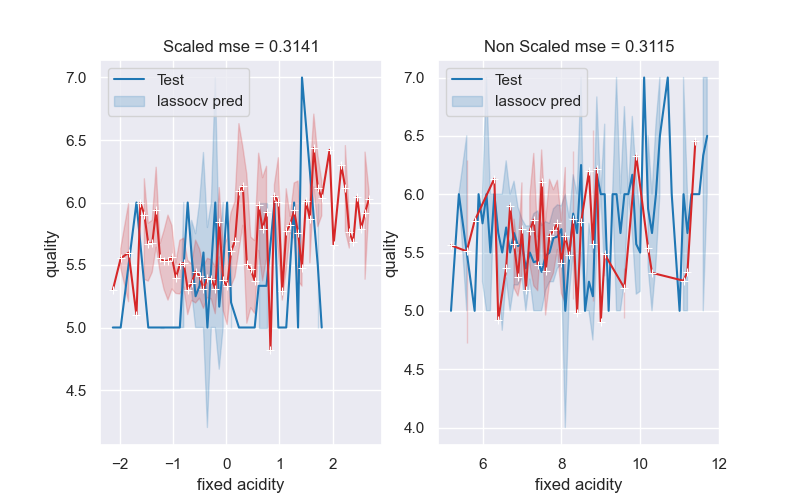

In [47]:
feat  = df.columns[0]

ypred3      = pd.DataFrame(enet_cv.predict(Xtest_sc), columns=['quality'])
ypred3_nosc = pd.DataFrame(enet_cv2.predict(X_test)  , columns=['quality'])

fign2, axn2 = plt.subplots(ncols=2,figsize=(8,5))

testdf      = Xtest_sc.assign(quality = y_test) #.sort_values(by=feat,ascending=True)
preddf      = Xtest_sc.assign(quality = ypred3) #.sort_values(by=feat,ascending=True)

testdf_nosc = X_test.assign(quality = y_test) #.sort_values(by=feat,ascending=True)
preddf_nosc = X_test.assign(quality = ypred3_nosc) #.sort_values(by=feat,ascending=True)

sns.lineplot(data=testdf,x=feat,y='quality',ax=axn2[0],color='tab:blue').set_title('Scaled mse = {}'.format(mean_squared_error(y_test,ypred3).round(4)))
sns.lineplot(data=preddf,x=feat,y='quality',ax=axn2[0],marker='+',color='tab:red')

sns.lineplot(data=testdf_nosc,x=feat,y='quality',ax=axn2[1],color='tab:blue').set_title('Non Scaled mse = {}'.format(mean_squared_error(y_test,ypred3_nosc).round(4)))
sns.lineplot(data=preddf_nosc,x=feat,y='quality',ax=axn2[1],marker='+',color='tab:red')

axn2[0].legend(['Test','lassocv pred']);
axn2[1].legend(['Test','lassocv pred']);

As can be seen, the the mse value is always the same, to this the l1_ratio array is a good approximation to solve the problems. I assume that the Elastic NetCV is kind of "cleaning" the data when is executed for the first time in this project, so the cleaning that I did in the second part is not really necesary, but is is good to see it anyway.